<a href="https://colab.research.google.com/github/yunwilliamyu/gaussian-minimizer-density/blob/main/Gaussian_minimizer_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Gaussian minimizer density experiments

Code associated with experiments/figures for the manuscript "*On minimizers and convolutional filters: a partial justification for the effectiveness of CNNs in categorical sequence analysis*" by Yun William Yu. [arXiv:2111.08452](https://arxiv.org/abs/2111.08452)

In [2]:
pip install mmh3 # Using fast Murmurhash library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 2.7 MB/s 


## Helper functions

In [3]:
import string
import re
import numpy as np

def random_string(n=10**6):
  '''generates a random genomic sequence'''
  ans = ''.join([str(x) for x in list(np.random.randint(4,size=n))])
  ans = ans.replace('0', 'A')
  ans = ans.replace('1', 'C')
  ans = ans.replace('2', 'G')
  ans = ans.replace('3', 'T')
  return ans

def preprocess_string(x):
  '''strip out any characters other than A, C, G, or T'''
  allow = "ACGT"
  return re.sub('[^%s]' % allow, '', x.upper())

def kmers(x,k):
  '''get kmers from preprocesssed string as a generator'''
  for i in range(len(x)-k+1):
    yield x[i:i+k]
  return

def onehot(x):
  '''Returns one-hot encoding of A,C,G,T string'''
  ans = np.zeros(len(x)*4)
  for i, c in enumerate(x):
    if c == 'A':
      ans[4*i] = 1
    elif c =='C':
      ans[4*i+1] = 1
    elif c =='G':
      ans[4*i+2] = 1
    elif c =='T':
      ans[4*i+3] = 1
    else:
      raise ValueError('Strings must only contain A, C, G, T. Please preprocess_string first')
  return ans

class cnn_filter:
  '''This class initializes a random Gaussian hash function for DNA sequences'''
  def __init__(self, k):
    '''k is k-mer size'''
    self.k = k
    self.constants = np.random.randn(k*4)
  def hash(self, x, signed=True):
    ox = onehot(x)
    ans = np.dot(ox, self.constants)
    if signed==False:
      ans = 1000*self.k + ans
    return ans


import mmh3

class mmh3_rand:
  '''This class initializes a random minimizer hash function by seeding randomly'''
  def __init__(self):
    self.seed = str(np.random.randn())
  def hash(self, x, signed=True):
    return mmh3.hash(self.seed + str(x), signed=signed)

def minimizers(x, k, w, hash_choice=mmh3):
  '''Get minimizers of x with k-mer size k with window size w
     
     The default hash choice is Murmurhash 3, which is a uniform hash function.
     You may also choose a custom hash function, such as cnn_filter, which we
     use to generate minimziers using a a random spherical Gaussian.
  '''
  gen = kmers(x, k)
  kmer_cache = [None]*w
  hash_cache = np.ones(w)*(0)
  loc_cache = np.ones(w)*(0)
  i = -1
  last_minimizer = (None, 0, 0)
  for x in gen:
    i = i+1
    kmer_cache[i%w] = x
    hash_cache[i%w] = hash_choice.hash(x, signed=False)
    loc_cache[i%w] = i
    min_loc = np.argmin(hash_cache)
    curr_minimizer = (kmer_cache[min_loc], hash_cache[min_loc], loc_cache[min_loc])
    if curr_minimizer != last_minimizer:
      last_minimizer = curr_minimizer
      yield curr_minimizer
  return 0

import collections
def frequencies(x, k):
  '''Computes the k-mer frequencies for string x'''
  gen = kmers(x, k)
  result = collections.Counter(gen)
  return result

def hamming(x, y):
  '''Computes Hamming distances for two equal-length strings'''
  return sum(chx != chy for chx, chy in zip(x,y))

def avg_distances(list1, opt_list2 = []):
  '''Computes avg of all pairwise Hamming distances between unique words'''
  if opt_list2 == []:
    list2 = list1
  else:
    list2 = opt_list2
  list1 = list(set(list1))
  list2 = list(set(list2))
  l1 = len(list1)
  l2 = len(list2)
  score = 0
  for i in range(l1):
    for j in range(l2):
      score = score + hamming(list1[i], list2[j])
  return score / (l1*l2)

def mutate_string(x, theta):
  '''Randomly mutates a string into other characters'''
  y = list(x)
  s = np.random.uniform(0,1,size=len(x)) < theta
  r = random_string(len(x))
  for i in range(len(y)):
    if s[i]:
      y[i] = r[i]
  return ''.join(y)



def experiment(k=8, w=16, n=12, N=500, mut_rate=0.02):
  '''Runs a single experiment and keeps track of density and distances'''
  example1 = random_string(n)
  example = ""
  r = int(np.ceil(N/n))
  for i in range(r):
    example = example + mutate_string(example1, mut_rate)
  example = example[:N]
  cnn_hash = cnn_filter(k)
  mmh3_hash = mmh3_rand()

  freq = frequencies(example, k)
  cnn_mins = minimizers(example, k, w, hash_choice=cnn_hash)
  rand_mins = minimizers(example, k, w, hash_choice=mmh3_hash)

  rand_mins_list = [x for x in rand_mins]
  hist_rand = collections.Counter([freq[x] for x, s, _ in rand_mins_list])
  rand_vals = np.asarray((sum(hist_rand.values()),#0,0)
               avg_distances([x for x,y,_ in rand_mins_list]),
               avg_distances([x for x,y,_ in rand_mins_list], list(freq.keys()))))

  cnn_mins_list = [x for x in cnn_mins]
  hist_cnn = collections.Counter([freq[x] for x, s, _ in cnn_mins_list])
  cnn_vals = np.asarray((sum(hist_cnn.values()),#0,0)
              avg_distances([x for x,y,_ in cnn_mins_list]),
              avg_distances([x for x,y,_ in cnn_mins_list], list(freq.keys()))))
  return (rand_vals, cnn_vals)

## Experiments for Figure 2
The code below runs all of the experiments for figure 2. The "num_data_points_per_dot" parameter controls how many repetitions are done. In the paper, we set the parameter to 400. Below, we have set the default to 25, as that will complete in a few minutes. Setting it to 400 may take upwards of an hour to complete. Alternately, we have precomputed values in the following cell.

In [5]:
num_data_points_per_dot = 25

results_table = []
for n in range(1,30):
  rvs = []
  cvs = []
  for i in range(num_data_points_per_dot):
    rv, cv = experiment(k=8, w=19,n=n, N=1007, mut_rate=0.133333)
    rvs.append(rv)
    cvs.append(cv)
    #if i%10 == 0:
      #print(i)
  output = np.concatenate(([n], sum(rvs)/len(rvs), np.std(rvs, axis=0)/np.sqrt(len(rvs)), sum(cvs)/len(cvs), np.std(cvs, axis=0)/np.sqrt(len(cvs))))
  results_table.append(output)
  #out_format = np.array_repr(output).replace('\n', '')
  print(list(output))

[1.0, 118.88, 2.875781597056403, 3.2126043142344805, 3.82133798557521, 0.04471685953942472, 0.02357910582562033, 107.52, 2.7619880403921786, 3.3074628822115715, 2.152669040981451, 0.039403807212291767, 0.019885385606866042]
[2.0, 115.76, 4.232985047376237, 4.4424399197740305, 2.0947782698892023, 0.18140911431042567, 0.17029970115477858, 108.16, 3.427052879241515, 4.456332524187433, 1.631372428355953, 0.16026460240247684, 0.16674363066215264]
[3.0, 108.88, 4.981780491183909, 5.185445485715877, 3.06949898191871, 0.14972754477966146, 0.13673599959074936, 99.76, 3.6800240638761563, 5.205114925802609, 2.082521548507962, 0.2124650867070414, 0.13304205122637003]
[4.0, 105.0, 5.157674433079149, 5.339380568260044, 1.6228370220080635, 0.09378845250671444, 0.08932014394235871, 101.64, 3.6355312023849975, 5.379373161121507, 1.239199741768856, 0.16450325915524625, 0.07935209887202158]
[5.0, 102.44, 5.216147351170275, 5.358606835250551, 1.2974806356936504, 0.11318239869282146, 0.10684270261991344, 1

You can set the below comment from "False" to "True" to use a cached value of the results_table, run with 400-time repetition. This is the actual data used in Figure 2 of the manuscript.

In [14]:
if False:
  results_table = [[1.0, 113.5325, 2.9648957817764705, 3.274724422860227, 0.6011737347680783, 0.012929991113581289, 0.007806365569198388, 112.4825, 2.837194156852359, 3.3307075024154034, 0.5532623558267814, 0.012020988081005702, 0.006696591361744396],
  [2.0, 114.9675, 4.320736024912923, 4.518130528693482, 0.47249720567956793, 0.04332606559410465, 0.039316561522897635, 108.635, 3.344046826724135, 4.562914462468855, 0.5363692175171876, 0.03994833764975197, 0.03889569744868257],
  [3.0, 105.6225, 4.823937459256455, 5.010686854492899, 0.47087682505619244, 0.032342393805537835, 0.030860468360104903, 101.53, 3.6518536410129996, 5.043007519104691, 0.5011713778738766, 0.04129740998668696, 0.030234506364479784],
  [4.0, 106.615, 5.027234272344045, 5.210644649101122, 0.43602401023338133, 0.028608480276806413, 0.027381048833397592, 104.415, 3.760970061373335, 5.237882814354646, 0.3932803548360889, 0.04112125803374272, 0.026794548074616936],
  [5.0, 104.905, 5.17600994310616, 5.333334047457352, 0.3952877907297415, 0.024344613267939172, 0.022971300442740778, 101.94, 3.853672570033209, 5.357473502201135, 0.3433889922522269, 0.03537949242392659, 0.02232447157029273],
  [6.0, 96.82, 5.311781850587892, 5.467461236054672, 0.46251378357839246, 0.020083729216649988, 0.018840014741716975, 90.5525, 3.959725865953553, 5.48570913001251, 0.4190532297632368, 0.03757717964252593, 0.018473187252928656],
  [7.0, 99.4525, 5.383771397337974, 5.530989843311522, 0.34576995152123907, 0.018901570451379284, 0.018025110498188793, 98.0925, 4.06155955653989, 5.551762225464696, 0.30930948801321956, 0.03542524410770882, 0.017814317728890243],
  [8.0, 95.2225, 5.427176135611754, 5.5751181551681555, 0.3642217516500078, 0.015603027308181305, 0.014790568875073847, 90.665, 4.086364552153044, 5.594463906955654, 0.3606514071787327, 0.03290195176598751, 0.014084868218446983],
  [9.0, 93.2375, 5.483934588206008, 5.626913010545269, 0.4003001803334595, 0.015085105297214999, 0.014413033059604757, 84.315, 4.139024829706546, 5.644069783991332, 0.3976832124945685, 0.03437478845848385, 0.014254243971882654],
  [10.0, 100.42, 5.530850123589255, 5.664813895688526, 0.3058537232076798, 0.013925981523284083, 0.013010072250588606, 99.58, 4.317283788718873, 5.681368064970655, 0.21005118423850905, 0.028262777210787255, 0.012646022423500932],
  [11.0, 98.8875, 5.558841564705926, 5.683201131338468, 0.3143041669704684, 0.012325095747738254, 0.011920879817973355, 96.12, 4.358257952116028, 5.698862172566947, 0.32500230768411453, 0.02463705728234305, 0.01155333579865472],
  [12.0, 97.475, 5.598301527089421, 5.723445671186325, 0.345558877038342, 0.011483334732439624, 0.011083252836457695, 92.675, 4.369718319250632, 5.736694143851755, 0.33970345523706424, 0.02740598863696031, 0.011129423975039592],
  [13.0, 95.8475, 5.6078490467565505, 5.734203392373919, 0.3026311440929371, 0.010992617665499043, 0.010285133668691066, 90.0975, 4.39733295286671, 5.751012374285616, 0.347195887612454, 0.02414029641743307, 0.010351423245418828],
  [14.0, 95.2925, 5.618350455889465, 5.744063106419599, 0.31494818522258555, 0.009789472152596412, 0.009165548059711388, 86.735, 4.372529551077975, 5.759871989323927, 0.3714827553198128, 0.024441623711656618, 0.009414695090434754],
  [15.0, 93.41, 5.635947126197371, 5.7579759379867745, 0.29954924469943184, 0.009900483135481936, 0.009539332649608507, 84.2225, 4.4411682607739404, 5.77517164465334, 0.36487324425750933, 0.025135375536655243, 0.009838811514118596],
  [16.0, 92.22, 5.662998676240766, 5.787841747617652, 0.32065012084825406, 0.008955834422681419, 0.00841063922095962, 81.8975, 4.4199635032661, 5.8038558366869415, 0.411998160645166, 0.025876202856115638, 0.008745783285629735],
  [17.0, 91.2875, 5.659786356215663, 5.782708976730499, 0.2927236057700164, 0.009208828254611577, 0.0084440452301103, 79.0275, 4.394848886587987, 5.80794644306913, 0.392210860858034, 0.025199138969716504, 0.008169527596030181],
  [18.0, 90.93, 5.680982416678429, 5.803462041732182, 0.31440459602238613, 0.00793359703819414, 0.0071774054038517, 77.69, 4.429706964262686, 5.8183501106926885, 0.4230806660673587, 0.025432478949715683, 0.007515814875898477],
  [19.0, 90.4525, 5.689037499634585, 5.812344282172813, 0.3393108595005471, 0.00801011210706009, 0.007097172741794039, 75.6175, 4.413492105151678, 5.824367699822517, 0.38910536410463425, 0.024037053866667633, 0.0074758222050012105],
  [20.0, 99.49, 5.703643142313142, 5.812674650746496, 0.2374073503495627, 0.008189442994288544, 0.007772691515240381, 99.19, 4.656828948722265, 5.816297169432769, 0.18030460337994686, 0.016684167705509467, 0.008023914128326837],
  [21.0, 98.5525, 5.713885210176658, 5.826052121588821, 0.2894488026836526, 0.007473389446065034, 0.006681013187653137, 98.7725, 4.6956059148215425, 5.83434674731832, 0.36202811959155845, 0.016604306117382835, 0.00674872258096673],
  [22.0, 98.9825, 5.721984210480539, 5.8382099168623345, 0.334448029408158, 0.007227899327772838, 0.006568298567988564, 99.1975, 4.699647985752863, 5.848412241091456, 0.4890385816834907, 0.01797699200150174, 0.006806531823302572],
  [23.0, 98.7875, 5.7404632737805255, 5.848232517997059, 0.32879455496555904, 0.006770093640721071, 0.0062143817820938295, 99.8425, 4.751160427270456, 5.857294809595553, 0.5661772994168874, 0.0164208320760961, 0.006238916813977645],
  [24.0, 99.0975, 5.743678413626766, 5.853247318313333, 0.3359612840417777, 0.006873026727796968, 0.00641671740319686, 99.72, 4.792342492207424, 5.869957858191936, 0.6417779989996539, 0.016630756722492628, 0.006806520421456523],
  [25.0, 99.27, 5.738928105047251, 5.841013676076585, 0.35845885398466565, 0.007085789790619595, 0.006518243464562883, 99.515, 4.746443465023765, 5.852278106894661, 0.6888664148439811, 0.01730806013549218, 0.006872113493753271],
  [26.0, 98.5175, 5.748313795493391, 5.85223604374951, 0.35926902785377984, 0.006279871088809727, 0.005710079059914195, 99.2175, 4.7707208043483345, 5.859162761232373, 0.7221152846845162, 0.016227170325355336, 0.0062144340646928435],
  [27.0, 98.99, 5.768166980699875, 5.870730180045479, 0.38895661711815643, 0.00558192964587125, 0.005121746008734317, 100.0925, 4.826829148799998, 5.8782277220060815, 0.7652678350584197, 0.015010439847926974, 0.005242616819819807],
  [28.0, 98.9625, 5.761362291034126, 5.866181349797247, 0.367988089990695, 0.005699314621854568, 0.005150145781430878, 98.9275, 4.811437530977558, 5.873509983703243, 0.7604229805673944, 0.015605016827570461, 0.005334949765826987],
  [29.0, 99.065, 5.7592900205082005, 5.863646135337295, 0.38725242090915335, 0.0057213497016018, 0.005193841833258946, 98.7525, 4.814507166927077, 5.871824848541195, 0.7259670167266556, 0.014444791961502649, 0.0053062326298909095]]

### Plotting Figure 2 of manuscript

Text(0.5, 1.0, 'Average distance from all k-mers')

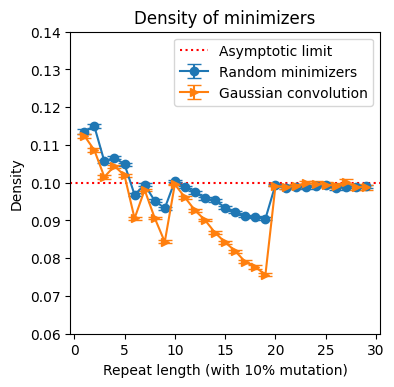

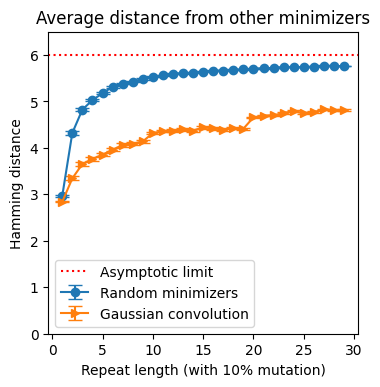

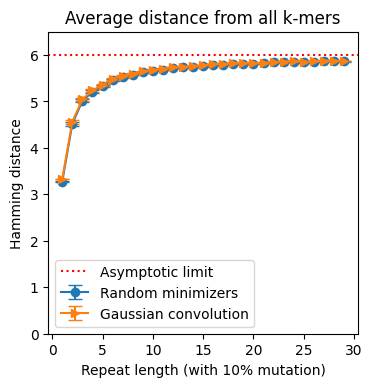

In [15]:
import matplotlib.pyplot as plt
res = np.vstack(results_table)
fig = plt.figure(figsize=(4, 4), dpi=100)
plt.axhline(0.1, color='r', linestyle=':', label='Asymptotic limit')
plt.errorbar(res[:,0], res[:,1]/1000, res[:,4]/1000, fmt='o-', capsize=5, label='Random minimizers')
plt.errorbar(res[:,0], res[:,7]/1000, res[:,10]/1000, fmt='>-', capsize=5, label='Gaussian convolution')
plt.legend()
plt.ylim([0.06, 0.14])
plt.ylabel('Density')
plt.xlabel('Repeat length (with 10% mutation)')
plt.title('Density of minimizers')

fig = plt.figure(figsize=(4, 4), dpi=100)
plt.axhline(6, color='r', linestyle=':', label='Asymptotic limit')
plt.errorbar(res[:,0], res[:,2], res[:,5], fmt='o-', capsize=5, label='Random minimizers')
plt.errorbar(res[:,0], res[:,8], res[:,11], fmt='>-', capsize=5, label='Gaussian convolution')
plt.legend()
plt.ylim([0, 6.5])
plt.ylabel('Hamming distance')
plt.xlabel('Repeat length (with 10% mutation)')
plt.title('Average distance from other minimizers')

fig = plt.figure(figsize=(4, 4), dpi=100)
plt.axhline(6, color='r', linestyle=':', label='Asymptotic limit')
plt.errorbar(res[:,0], res[:,3], res[:,6], fmt='o-', capsize=5, label='Random minimizers')
plt.errorbar(res[:,0], res[:,9], res[:,12], fmt='>-', capsize=5, label='Gaussian convolution')
plt.legend()
plt.ylim([0, 6.5])
plt.ylabel('Hamming distance')
plt.xlabel('Repeat length (with 10% mutation)')
plt.title('Average distance from all k-mers')


#Figure 3. Density experiments on real human telomeres

We extracted the parts of the human chromosomes annotated as Telomeres by the Telomere2Telomere project version 2.0. (code found in Github). Then, we applied either random minimizers or Gaussian convolutions on the real telomeres.

In [8]:
import urllib.request, json 
with urllib.request.urlopen("https://github.com/yunwilliamyu/gaussian-minimizer-density/raw/main/telomere_dict.json") as url:
    telomere_dict = json.load(url)

#$telomere_dict = 
#for k, v in telomere_dict.items():
#  print(k)

def telomere_experiment(tel, k=8, w=16):
  '''Runs a single experiment and keeps track of density and distances'''
  example = tel
  cnn_hash = cnn_filter(k)
  mmh3_hash = mmh3_rand()

  freq = frequencies(example, k)
  cnn_mins = minimizers(example, k, w, hash_choice=cnn_hash)
  rand_mins = minimizers(example, k, w, hash_choice=mmh3_hash)

  rand_mins_list = [x for x in rand_mins]
  hist_rand = collections.Counter([freq[x] for x, s, _ in rand_mins_list])
  #print()
  #print(sum(hist_rand.values())/(len(tel)-k+1))
  rand_vals = np.asarray((sum(hist_rand.values())/(len(tel)-k+1),#0,0)
               avg_distances([x for x,y,_ in rand_mins_list]),
               avg_distances([x for x,y,_ in rand_mins_list], list(freq.keys()))))

  cnn_mins_list = [x for x in cnn_mins]
  hist_cnn = collections.Counter([freq[x] for x, s, _ in cnn_mins_list])
  cnn_vals = np.asarray((sum(hist_cnn.values())/(len(tel)-k+1),#0,0)
              avg_distances([x for x,y,_ in cnn_mins_list]),
              avg_distances([x for x,y,_ in cnn_mins_list], list(freq.keys()))))
  return (rand_vals, cnn_vals)

for k, v in telomere_dict.items():
  print(telomere_experiment(v, k=8, w=19))
  break

#results_table = []
#for k, v in telomere_dict.items():
#  output = [k] + [x for x in rv] + [x for x in cv]
#  results_table.append(output)



(array([0.08252589, 5.18595041, 5.35002895]), array([0.07216839, 3.55555556, 5.36390658]))


## Experiments for Figure 3
The code below runs all of the experiments for figure 3. The "num_data_points_per_dot" parameter controls how many repetitions are done. In the paper, we set the parameter to 400. Below, we have set the default to 25, as that will complete in a few minutes. Setting it to 400 may take upwards of an hour to complete. Alternately, we have precomputed values in the following cell.

In [9]:
num_data_points_per_dot = 25

results_table = []
for n, (k, v) in enumerate(telomere_dict.items()):
  rvs = []
  cvs = []
  for i in range(num_data_points_per_dot):
    rv, cv = telomere_experiment(v, k=8, w=19)
    rvs.append(rv)
    cvs.append(cv)
    #if i%10 == 0:
      #print(i)
  output = np.concatenate(([n], sum(rvs)/len(rvs), np.std(rvs, axis=0)/np.sqrt(len(rvs)), sum(cvs)/len(cvs), np.std(cvs, axis=0)/np.sqrt(len(cvs))))
  results_table.append(output)
  #out_format = np.array_repr(output).replace('\n', '')
  print(list(output))

[0.0, 0.07893083862345474, 5.016461445234804, 5.290837540819261, 0.0012662173019022806, 0.02834988000575934, 0.011276555656781458, 0.07498830604744403, 4.028238187085543, 5.353694524255108, 0.000873937244144918, 0.08515198027819894, 0.01363974155565086]
[1.0, 0.07474856970791931, 5.501000945212349, 5.726612003978431, 0.0006648076121971861, 0.020203025061310366, 0.008361137609539203, 0.07208672086720867, 4.672041729092944, 5.751256632520934, 0.0004519521358456783, 0.059728341387150455, 0.013346936882091032]
[2.0, 0.08436404119120512, 4.753012835230547, 4.939831075459539, 0.001025824312426329, 0.037942574345103605, 0.0126324574351559, 0.07975507932090176, 3.6115023704192, 4.974424325200495, 0.0005772053281135694, 0.11544735937150978, 0.013250003917322048]
[3.0, 0.07862818336162988, 5.293063189024935, 5.551782913300452, 0.001015334418318229, 0.026320192410500542, 0.008206739517733522, 0.07543633276740239, 4.7083485122730595, 5.630614895908915, 0.0007041053050707193, 0.05242232071439501, 0

You can set the below comment from "False" to "True" to use a cached value of the results_table, run with 400-time repetition. This is the actual data used in Figure 3 of the manuscript.

In [18]:
if False:
  results_table = [[0.0, 0.07708820581356497, 5.044141306791825, 5.303886449892763, 0.0002510155417412569, 0.007174093944839513, 0.0025241669610420363, 0.07525141997995327, 4.142322804672389, 5.327851052744193, 0.00018545580967634692, 0.0234314399977094, 0.0037283458591083306],
  [1.0, 0.07438497440529962, 5.510279000318193, 5.731375608824916, 0.00014684249646822555, 0.005558901142878913, 0.002237117568048873, 0.07255344775669986, 4.674591309164426, 5.742414489084824, 0.00012907798707410722, 0.01681881656490639, 0.003240150814195978],
  [2.0, 0.08319023100473143, 4.784424904092488, 4.9515692215622655, 0.00022383186219703514, 0.007324339378991367, 0.002429600973029544, 0.07991720011132757, 3.644252731410641, 4.9657136700824935, 0.00020218018364059507, 0.031892325018254064, 0.0035736600427064636],
  [3.0, 0.07798981324278438, 5.319243313946961, 5.559063769872462, 0.0002331129581754503, 0.00573967216908715, 0.0022759945443463743, 0.07607724957555181, 4.661798778973958, 5.590694532491372, 0.0001764930969925507, 0.013595473720924659, 0.003861053654026613],
  [4.0, 0.07276942355889726, 4.917665171287073, 5.292056717855968, 0.00013482396157819322, 0.009039587844343448, 0.002608485803598756, 0.07151897601145725, 4.07158773080194, 5.314882730052493, 0.00012491143659579802, 0.023881788749542283, 0.0036475530583129764],
  [5.0, 0.0984793554884191, 5.0452550035164, 5.22731026282755, 0.0004247280608305013, 0.005577583776912027, 0.0018313511899601571, 0.09276183282980867, 3.77067086265222, 5.251567925353412, 0.00040349529125110307, 0.03127629331855846, 0.003797894957607459],
  [6.0, 0.07717148280953391, 5.24486836597849, 5.463399902032818, 0.0002280679607938009, 0.005147148736002624, 0.002157122914025757, 0.07420217253743931, 4.467278352604052, 5.4917882145347106, 0.0001534203481052893, 0.01677666126850684, 0.00403829310348797],
  [7.0, 0.07758620689655173, 5.35871262754189, 5.60279304537683, 0.0002034279220788953, 0.006081570532509702, 0.0026663489101059193, 0.0748806366047745, 4.631515577404247, 5.634328762628896, 0.00014542276637582516, 0.015324876090689702, 0.004494496474548122],
  [8.0, 0.07055816937553458, 5.161224362747391, 5.509767039470716, 0.00014837919642438576, 0.00882246139338944, 0.0024926636218649146, 0.06909431137724548, 4.088063215996401, 5.530883604493072, 0.0001180453412082318, 0.0293071212738391, 0.0034802403832845845],
  [9.0, 0.0765012536564981, 5.55770349240658, 5.817898797826739, 0.00017628496664469056, 0.005597144641640963, 0.0022062630504261663, 0.07427392394483913, 4.788322815771259, 5.828311735571934, 0.00013544034848786226, 0.014643975064496096, 0.0032335967847849966],
  [10.0, 0.07547181372549021, 5.371058193367872, 5.722485467762876, 0.00020613909900117126, 0.007102842097927999, 0.0027823522275367612, 0.0731127450980392, 4.551108595704902, 5.72890528064484, 0.00014890651446616214, 0.01680742172499866, 0.003293564418673828],
  [11.0, 0.06767206815903774, 5.496954156543068, 5.798791713875078, 8.599464799523923e-05, 0.00607982572805617, 0.00251024704516758, 0.06677915135315735, 4.689567705919629, 5.81799074430349, 6.770034099347417e-05, 0.018774549271491907, 0.0034542070893697403],
  [12.0, 0.07394240317775577, 5.69384523677629, 5.863710657698889, 0.00016373228041250437, 0.003917235896511183, 0.001361052056931657, 0.07270109235352538, 5.0747107536343945, 5.86785408654058, 0.00013091168384739697, 0.008230100336031661, 0.002130931409396606],
  [13.0, 0.07680141942666299, 5.577427322153366, 5.778915836378048, 0.00022580945828533583, 0.004726257939993735, 0.0018819430096671183, 0.07411981630949069, 4.834716308713818, 5.790500454744241, 0.00015363095546069437, 0.011491431926439779, 0.0019989755229841747],
  [14.0, 0.07979851418280062, 4.632703748230258, 4.8856466084670584, 0.0002455640079640883, 0.009206680714432465, 0.0032120974971371037, 0.0770441242683476, 3.342121232551831, 4.9019104501979625, 0.0001916288731454207, 0.036658353353237846, 0.006082895055708408],
  [15.0, 0.07882156289176766, 4.926199504928667, 5.104517237163368, 0.00020875524390602328, 0.00622022918667593, 0.0017891283752207072, 0.076541997492687, 3.7180049215378337, 5.132717575655313, 0.0001579664880755573, 0.03154901384997079, 0.0026577895817717816],
  [16.0, 0.06639595103578154, 4.320730777490107, 4.859598952452463, 8.439971393574397e-05, 0.02139297510233342, 0.004944650531631612, 0.06534016007532953, 2.8497036141110943, 4.906216586443859, 7.167371203592319e-05, 0.05051107576145928, 0.008324766426374069],
  [17.0, 0.08033812285789611, 5.396657074667543, 5.62616301588637, 0.00026545007679080535, 0.005680832655279904, 0.0025626879186729005, 0.07751845504877411, 4.63456922830135, 5.643830247566274, 0.00018078420464927961, 0.013963235921732922, 0.0030611201963554034],
  [18.0, 0.0821514084507042, 4.5656078258210435, 4.785604794102068, 0.00022221413646737994, 0.008192243678683212, 0.002694698533244761, 0.0789058098591549, 3.4200318992542806, 4.803652658797297, 0.00017830339229610797, 0.029704895561945315, 0.005196720784143182],
  [19.0, 0.07833333333333335, 5.094914375496049, 5.371770775217888, 0.00024687993843195734, 0.007548541068909341, 0.0026769238357854056, 0.07598728965270322, 4.053119652836881, 5.390157769357488, 0.0001691359345820854, 0.024958786017394242, 0.0037714574009299244],
  [20.0, 0.077977908025248, 5.478622536483121, 5.721756325559173, 0.00026173660525214543, 0.005422642666480721, 0.002151175979511485, 0.07502855425308087, 4.6616677555873505, 5.728892613750205, 0.00016343551022805297, 0.014405920206250648, 0.003202085797154239],
  [21.0, 0.07687072503419973, 5.388156445946547, 5.574040059801316, 0.00012305354052301605, 0.004701880139156566, 0.0018907272090921453, 0.07617419060647515, 4.693140015057185, 5.596315761949856, 0.0001340883228472789, 0.012418751677971906, 0.0034332682226901135],
  [22.0, 0.09599968612680473, 5.617108485756752, 5.743719670801909, 0.0003243651974981464, 0.0030524906013980986, 0.0012815201106862735, 0.09239642184557435, 4.758552163517453, 5.753498986431293, 0.00033424524969044643, 0.01389117593246351, 0.002295807913609464],
  [23.0, 0.07270999275887034, 5.506778326946391, 5.7329584424934605, 0.00013809189086698258, 0.005305833072689362, 0.002155322672935456, 0.07125633598841416, 4.874587137316613, 5.754425762781335, 0.00010657460154297893, 0.01125163158015883, 0.0030622353378538993],
  [24.0, 0.08531161916692763, 5.2980541648303605, 5.5512896538691825, 0.0002558719329805287, 0.0060009714067738055, 0.0027104796420457135, 0.08172643282179776, 4.453498163829256, 5.572423707004192, 0.0002066192474271755, 0.016946562954827552, 0.005834997367058738],
  [25.0, 0.07053128689492325, 5.756260470806941, 5.932422389075708, 0.0001206935245891699, 0.0030106463683829284, 0.000812064964731667, 0.06934966548602911, 5.082052419385939, 5.935303625504645, 0.0001019716588324295, 0.00917888093261656, 0.001592813861816314],
  [26.0, 0.07064066154360175, 5.526667439245273, 5.725055192964783, 9.983597341407264e-05, 0.006016331481239018, 0.0025193747819369262, 0.06993818910791853, 4.5273029668177704, 5.726786369572986, 9.604566379634469e-05, 0.024565761741832188, 0.0034730863028609527],
  [27.0, 0.07412476216363138, 5.603511931237635, 5.781339771056895, 0.00017600703284268216, 0.004518467347181936, 0.0019594905903492473, 0.0720712150040772, 4.821229470671253, 5.788915096818703, 0.00012379619727554835, 0.012419348388843104, 0.0021235147867498276],
  [28.0, 0.06872127037191811, 5.82589319827228, 5.976900532517112, 7.036905189740454e-05, 0.0024420481990737397, 0.000574268775385383, 0.06872962808190555, 5.154109987268513, 5.977667054209763, 7.746142085980708e-05, 0.007221831990362394, 0.0011314368222854014],
  [29.0, 0.07875862068965506, 5.056539305513521, 5.364499923232963, 0.00026144940133584506, 0.008345139338906207, 0.002660921284564412, 0.07676392572944286, 4.239061314810772, 5.386550962223538, 0.00021564676785123987, 0.021269999029713584, 0.00407063681259125],
  [30.0, 0.08065961591984414, 5.672794852597543, 5.8122573278151535, 0.0002137916692845414, 0.0035958774888252623, 0.0014809669359602078, 0.07771221820205955, 4.99875292436254, 5.825987821946229, 0.00017421721651495516, 0.008843356176878484, 0.002582425380458135],
  [31.0, 0.07683651271753673, 5.325155593521618, 5.608332934287112, 0.00022059643205383792, 0.0068351543053268085, 0.0030037541234317665, 0.07459086345381512, 4.405114300094034, 5.637815194813714, 0.00015376485332435692, 0.020655590636199084, 0.004773400463216459],
  [32.0, 0.07718858465098345, 5.69878372927597, 5.874961983987005, 0.00016835395597721405, 0.003868102029102345, 0.0012208439259356087, 0.07516101041264948, 5.084164631143181, 5.887623166639917, 0.00015003482668409196, 0.00878729033116804, 0.0019490529402255018],
  [33.0, 0.07324738793394002, 5.743030938879698, 5.897487646571218, 0.0001356818095889753, 0.003729873697700381, 0.001392835339855796, 0.07184108527131781, 5.065915982300621, 5.908920794934728, 0.0001184558630744468, 0.008539273970835365, 0.001906776491585221],
  [34.0, 0.07020633834929312, 4.342563406524672, 4.788415118986924, 0.00012470498527593457, 0.017371561201562347, 0.0036138534435345647, 0.06864455084359325, 2.959139781784719, 4.80535783971287, 0.0001109219767009853, 0.04148484678347738, 0.006365180723288245],
  [35.0, 0.07475323624595466, 5.479473222706298, 5.704273752774669, 0.00020894619928087587, 0.0057277386848888735, 0.002713267651895054, 0.07224595469255662, 4.533570537387054, 5.7134828618858, 0.00013556297850971796, 0.018036918373615148, 0.003399358327754088],
  [36.0, 0.07288758880066863, 5.732245536291585, 5.876721654754688, 0.0001280251409924848, 0.0029940455981271054, 0.0009591475186664278, 0.07222106142916847, 5.06913425368866, 5.882736276796539, 0.00011873827838785862, 0.0101319783098027, 0.002136930145150609],
  [37.0, 0.07672330784480312, 4.875045239867336, 5.1721335009339535, 0.00019184816254153464, 0.009097239528605545, 0.0028603823436065463, 0.0741135655621637, 3.8886219859878723, 5.1906340074461745, 0.0001531486589170814, 0.025158785471844636, 0.004660754845026609],
  [38.0, 0.0848109068115337, 5.416083594637607, 5.627608817619143, 0.00034667200470947084, 0.00590215796072731, 0.0028316740215752903, 0.0813320100292519, 4.622727041205244, 5.656498687619542, 0.00023667204866066003, 0.014736117923915557, 0.0035083083818457776],
  [39.0, 0.07746832435856824, 5.331795454962409, 5.553805964495876, 0.0002399784954397165, 0.0049630027064756785, 0.00198719108630764, 0.07485745961355718, 4.613918189654755, 5.585970927033388, 0.00017342187686104373, 0.015012724541298345, 0.002922520716358346],
  [40.0, 0.07602935911206588, 5.315719002566858, 5.632410264093153, 0.0002295023970668711, 0.008312947666484926, 0.0035354419524753185, 0.07375134264232011, 4.5128236745702335, 5.642182071453708, 0.00015161474599546815, 0.016102584284173254, 0.004370620334537088],
  [41.0, 0.08071890394088677, 5.3076447731500185, 5.559992462873202, 0.00018498505392609049, 0.007390570592571198, 0.0033454216950766216, 0.07819966133004935, 4.5738161721808135, 5.582647461096826, 0.0001473958416847827, 0.014217834995157583, 0.004485510613258364],
  [42.0, 0.06573755429335114, 4.835961345909314, 5.201711646492372, 7.395196255786073e-05, 0.013025317398483125, 0.0026573111553659487, 0.06475526227865014, 3.6203488476819206, 5.223233255393021, 6.473808499578388e-05, 0.03895099794728935, 0.004157337939775957],
  [43.0, 0.07410695187165776, 5.444403405038485, 5.666500904812601, 0.00020110436039009368, 0.005625706351140126, 0.002582703318405019, 0.07129572192513373, 4.63249610264895, 5.683811766033491, 0.00011460228359549322, 0.013908129408244662, 0.0028949668954221974],
  [44.0, 0.06925538863487919, 4.851361160173724, 5.0974973539449495, 0.0001251677390100486, 0.007844391605986305, 0.0031641564345265757, 0.06777650772915303, 3.80747969123471, 5.1275644720672595, 9.043288923809632e-05, 0.027615920321064476, 0.004983131755006799],
  [45.0, 0.07638986854761147, 5.608064666035639, 5.82529688208231, 0.0001846829243597325, 0.00467270911071197, 0.001763030942363002, 0.07418964411670417, 4.874329692156952, 5.83478826972776, 0.0001397802068863881, 0.01154097787218793, 0.0021652667421856796],
  [46.0, 0.06870296036126447, 5.716440219567868, 5.949323397765648, 9.04358039115575e-05, 0.004258585699003541, 0.0012160320868394138, 0.067584044154541, 5.011216469668399, 5.954587519130495, 7.894481628102188e-05, 0.010444556169992859, 0.0017987394979529527],
  [47.0, 0.07534885828198624, 4.456960977474535, 4.742873842348048, 0.0001947177640936318, 0.011759729645500577, 0.00327267735782584, 0.07279992750996744, 3.142311550513282, 4.760295749505266, 0.00014332140059039386, 0.03668295604520922, 0.004362435713456324],
  [48.0, 0.06357068876229927, 5.633919643899683, 5.955458552853731, 3.3627853210812686e-05, 0.005475920807002628, 0.0012126981322050242, 0.06343129639219745, 5.024759569882251, 5.960562230411913, 3.099780372534228e-05, 0.010933779933511691, 0.001891271744946512],
  [49.0, 0.07210302153648344, 4.689370655721143, 4.8591464555649075, 0.0001342936698088269, 0.007052321191294462, 0.0026115873455089017, 0.07070435551269694, 3.4761130435082435, 4.870793238295465, 9.357939671043405e-05, 0.03149357549052284, 0.0035616965861161734]]

### Plotting Figure 3 of manuscript

Note that we manually annotate the x-axis ticks with the telomere number. For space reasons, instead of specifying the location on each chromosome, we have simply labelled them "a", "b", and sometimes "c" if there are three annotated telomeric regions on the chromosome.

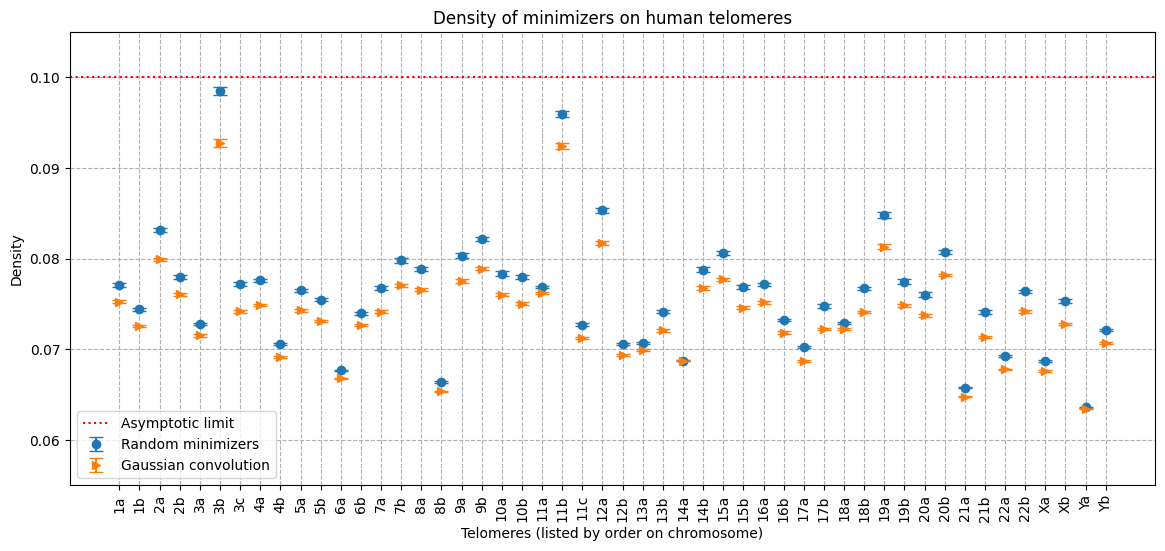

In [26]:
import matplotlib.pyplot as plt
res = np.vstack(results_table)
fig = plt.figure(figsize=(14, 6), dpi=100)
plt.axhline(0.1, color='r', linestyle=':', label='Asymptotic limit')
plt.errorbar(res[:,0], res[:,1], res[:,4], fmt='o', capsize=5, label='Random minimizers')
plt.errorbar(res[:,0], res[:,7], res[:,10], fmt='>', capsize=5, label='Gaussian convolution')
plt.legend()
plt.ylim([0.055, 0.105])
plt.ylabel('Density')
plt.xlabel('Telomeres (listed by order on chromosome)')
plt.xticks(np.arange(50), ['' + x for x  in ['1a', '1b',
                   '2a', '2b',
                   '3a', '3b', '3c',
                   '4a', '4b',
                   '5a', '5b',
                   '6a', '6b',
                   '7a', '7b',
                   '8a', '8b',
                   '9a', '9b',
                   '10a', '10b',
                   '11a', '11b', '11c',
                   '12a', '12b',
                   '13a', '13b',
                   '14a', '14b',
                   '15a', '15b',
                   '16a', '16b',
                   '17a', '17b',
                   '18a', '18b',
                   '19a', '19b',
                   '20a', '20b',
                   '21a', '21b',
                   '22a', '22b',
                   'Xa', 'Xb',
                   'Ya', 'Yb', 'A', 'B'
                   ]], rotation = 90
           )
plt.title('Density of minimizers on human telomeres')

plt.grid(which='major', axis='both', linestyle='--')
